This first task is the classification of raw EMG signals into different hand gestures, using signal processing and ML techniques. To achieve this, the following steps are performed: 
- Data exploration
- Preprocessing 
- Feature extraction
- Classification 

Finally, the trained models are tested on unseen EMG test data from a different subject.

Import libraries

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# signal processing
from scipy.fft import rfft, rfftfreq
from scipy import signal

# classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
import itertools

## Data Exploration
This section takes a look at the raw EMG signals for subject 1. First, subject 1s data is loaded (from two files), which will be used for training.

In [113]:
def load_data(paths):
    datasets = []
    for path in paths:
        data = pd.read_csv(path, sep='\t')  # values separated by tab
        data.rename(columns={'class':'target'}, inplace=True) # needed as 'class' can make some things not work
        datasets.append(data)
    dataset = pd.concat(datasets)
    dataset.reset_index(drop=True, inplace=True)
    return dataset

data_paths = [r'...\EMG_data_for_gestures-master\01\1_raw_data_13-12_22.03.16.txt',
             r'...\EMG_data_for_gestures-master\01\2_raw_data_13-13_22.03.16.txt']

raw_emg = load_data(data_paths)

Look at the shape and structure of the data 

In [114]:
print('Shape of data: %s' % str(raw_emg.shape))
print('Preview of data:') 
print(raw_emg.head())

Shape of data: (121170, 10)
Preview of data:
   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0     1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
1     5   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2     6  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3     7  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4     8  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel8  target  
0  -0.00001       0  
1  -0.00001       0  
2   0.00001       0  
3   0.00001       0  
4   0.00001       0  


Define function to plot all channels, between given indices and plot

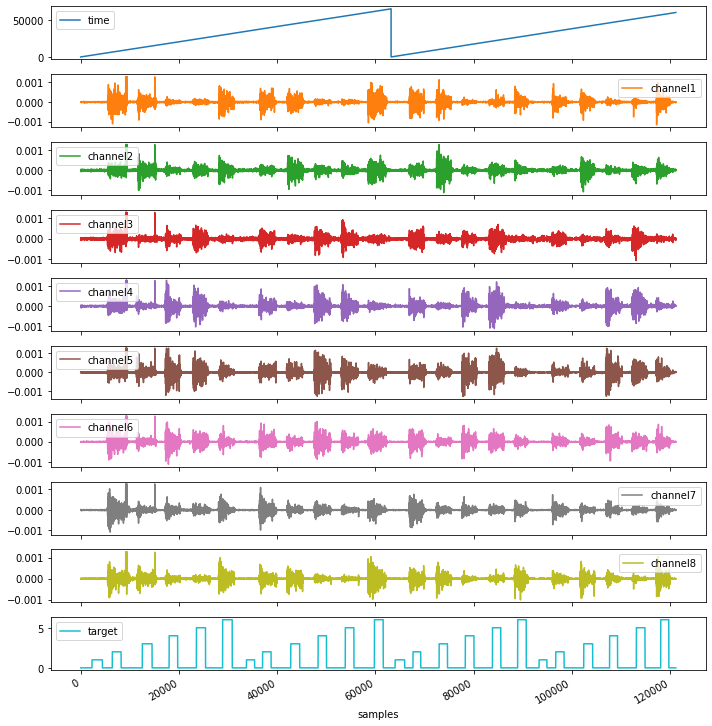

In [115]:
def plot_all_channels(data, idx_start, idx_end):
    data.iloc[idx_start:idx_end, :].plot(subplots=True, figsize=(10,10))
    plt.tight_layout()
    plt.xlabel('samples')
    plt.show()
    
plot_all_channels(raw_emg, 0, len(raw_emg))

##### Frequency domain
As per the description of the dataset (in Latent Factors Limiting the Performance of sEMG-Interfaces), the sampling frequency is 1 kHz. Using this, plot the frequency spectrum of one channel of EMG signal. 

Define function to plot the frequency spectrum of a signal.

In [116]:
SAMPLING_FREQ = 1000
def plot_freq_domain(signal):
    num_samples = len(signal)
    yf = rfft(signal) # rfft as input is real numbers
    xf = rfftfreq(num_samples, 1/SAMPLING_FREQ) # get frequencies
    plt.plot(xf, np.abs(yf)) # abs because yf is complex 
    plt.ylabel('Amplitude')
    plt.xlabel('Hz')
    plt.show()

In literature, a commonly seen frequency range to filter EMG signals to is 10/20 Hz - 450 Hz. Below this range are movement artefacts, and above is undesired high frequency noise. A bandpass filter will be used to obtain frequencies in this range. The signals are also filtered at 50 Hz with a bandstop filter to remove mains interference. 

In [117]:
def get_filter(filter_type, cutoff):
    nyquist_freq = SAMPLING_FREQ/2 # Hz
    cutoff_freqs_frac = [x/nyquist_freq for x in cutoff] # cutoff frequency given as fraction of Nyquist frequency
    b, a = signal.butter(FILTER_ORDER, cutoff_freqs_frac, btype=filter_type) # note analog = False
    return b, a

FILTER_ORDER = 4
    
cutoff_freqs = [20, 450] # Hz
b_bandpass, a_bandpass = get_filter('bandpass', cutoff_freqs)

cutoff_freqs = [45, 55]
b_bandstop, a_bandstop = get_filter('bandstop', cutoff_freqs)

Check the filter works as expected on channel 1 of data, actual filtering will be carried out in the preprocessing function further on. 

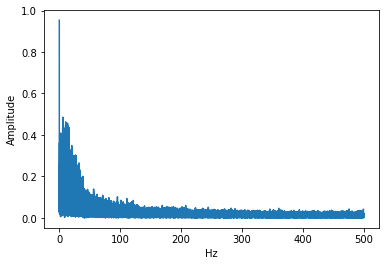

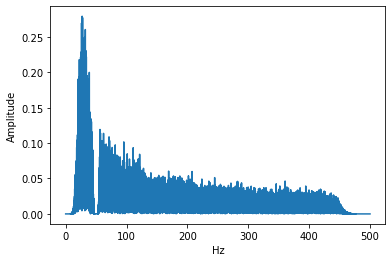

In [118]:
unfiltered_emg = raw_emg.to_numpy()[:, 1]
plot_freq_domain(unfiltered_emg) # plot fft of unfiltered signal
filtered_emg_1 = signal.filtfilt(b_bandpass, a_bandpass, unfiltered_emg, padlen=0, axis=0) # band pass filtering
filtered_emg = signal.filtfilt(b_bandstop, a_bandstop, filtered_emg_1, padlen=0, axis=0) # notch filtering
plot_freq_domain(filtered_emg) # plot fft of the filtered signal

These plots show the filters work as expected. 

##### Missing data
The dataset description says there are no missing values, but to check:

In [119]:
print(raw_emg.isnull().sum())

time        0
channel1    0
channel2    0
channel3    0
channel4    0
channel5    0
channel6    0
channel7    0
channel8    0
target      0
dtype: int64


##### Dataset columns
The columns are defined as:
- 1) Time - time in ms
- 2-9) Channel - eight EMG channels of MYO Thalmic bracelet
- 10) Class of gestures

Looking at the 'time' column of the dataset:

In [120]:
print(raw_emg['time'].iloc[0:10])

0     1
1     5
2     6
3     7
4     8
5     9
6    10
7    11
8    12
9    13
Name: time, dtype: int64


Given the 1 kHz sampling frequency, and the time is in ms, ideally the row index would match the time value of the same row, e.g. on the 1000th row, time would = 1000. However, there is a mismatch between the two, and this mismatch increases as time goes on: 

In [121]:
print(raw_emg['time'].iloc[930:934])

930     998
931     999
932    1000
933    1001
Name: time, dtype: int64


The missing rows could be filled e.g. with linear interpolation. For reasons explained later, individual samples are not being used to train the classifiers, windows of data containing multiple samples are. Therefore, it is the overall statistics of the windows that are important, rather than the individual samples. For this reason, and the fact there are some larger gaps in the data, e.g. below (10 ms of missing data), the missing rows were not imputed. 

In [122]:
print(raw_emg['time'].iloc[28:34])

28    33
29    34
30    35
31    45
32    47
33    48
Name: time, dtype: int64


##### Class labels
As per the class definitions, data labelled class 0 is defined as unmarked data. As can be seen by the plot of class labels over raw data, there is data labelled class 0 during which a gesture is being performed. Using this data in classifier training would therefore decrease classification performance. For this reason, and because we do not need to classify unmarked data, data labelled 0 is dropped.  

##### Class distribution
Classifiers trained on unbalanced datasets will perform poorly on test data, as they tend to predict the dominant class. The number of instances of each class are as follows:

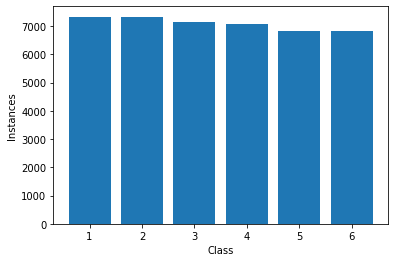

In [123]:
def plot_class_instances(y):
    targets = y.unique()
    instances = y.value_counts().to_list()
    plt.bar(targets, instances)
    plt.xlabel('Class')
    plt.ylabel('Instances')
    plt.show()
    
# plot class instances with data labelled 0 removed
plot_class_instances(raw_emg[raw_emg.target != 0]['target'])

The classes are indeed balanced.

## Preprocessing
The raw EMG signals are processed as described above in the following preprocess function.

In [124]:
def preprocess(data):

    # drop time
    data.drop('time', axis=1, inplace=True)
    
    # drop class 0 data
    data = data[data.target != 0]
    
    # reset the index of the dataframe
    data.reset_index(drop=True, inplace=True)
    
    # filter the data
    data_np = data.loc[:,'channel1':'channel8'].to_numpy()
    filtered_data_1 = signal.filtfilt(b_bandpass, a_bandpass, data_np, padlen=0, axis=0) # high pass filtering
    filtered_data_2 = signal.filtfilt(b_bandstop, a_bandstop, filtered_data_1, padlen=0, axis=0) # notch filter
    
    # create new df for filtered data
    new_data = pd.DataFrame(data=filtered_data_2, columns=data.columns[0:8])
    new_data['target'] = data['target'].copy()
    
    return new_data

In [125]:
# carry out preprocessing
raw_emg = preprocess(raw_emg)

## Feature Extraction
Raw EMG signals are noisy and large in size, thus unsuitable for training a classifier directly. Instead, features that capture the important information about the signal are extracted. These features should describe the signals in a way that discrimination between different gestures is based on these features possible. Features are extracted during the steady-state contraction of each different gesture. This dataset is already labelled, so segmentation to find the data during steady-state is not required. 

To extract the features, a sliding window is passed over the data of each sepearate class and features are computed. The sliding window has two parameters:
- window length - number of samples in data
- overlap - number of samples the next window overlaps the previous one

In this work a 500 sample window (~500 ms) is used, sufficiently long enough to capture the important information, with a 400 sample overlap (i.e. next window starts 100 samples after previous one started). In each window, features from both the time and frequency domain of the signals are extracted: 

Time domain:
 - Mean absolute value
 - Root mean square
 - Variance
 - Zero crossings - the number of times the signal crosses zero on the y axis
 
Frequency domain:
 - Peak frequency - frequency of the peak with greatest power
 - Peak power - greatest power in PSD
 
For each of these features (besides variance), a custom function has been defined.

Mean absolute value function

In [126]:
def MAV(x):
    x_abs = x.abs() 
    x_mav = x_abs.mean()
    return x_mav

Root mean square

In [127]:
def RMS(x):
    x_squared = x**2
    x_squared_mean = x_squared.mean()
    x_rms = np.sqrt(x_squared_mean)
    return x_rms

Zero crossing

In [128]:
def ZC(x):
    zc = ((np.array(x)[:-1] * np.array(x)[1:]) < 0).sum()
    return zc

Peak power

In [129]:
def PP(x):
    freqs, psd = signal.welch(x)
    peak_power = np.max(psd)
    return peak_power

Peak frequency

In [130]:
def PF(x):
    freqs, psd = signal.welch(x)
    peak_power_idx = np.argmax(psd)
    peak_freq = freqs[peak_power_idx]
    return peak_freq

Feature extraction is performed with the feature_extraction function below. The pandas rolling function is a sliding window of step size 1 (no argument for overlap). Thus, for each 500 sample window the features are extracted, and then downsampled with [::overlap] to get the correct overlap. 

In [131]:
# window parameters in samples
WINDOW_LENGTH = 500
OVERLAP = 100 # sample every 100th window to get 400 sample overlap

def feature_extraction(data):
    
    targets = data['target'].unique() # list of integers of the different classes
    feature_spaces = [] # list to append the feature space of each different class into

    for target in targets: # i.e. for each hand gesture
        
        # get data of the correct class
        target_data = data.loc[data['target']==target].copy() 
        target_data.reset_index(drop=True, inplace=True)
        
        # drop target column, not needed now
        target_data.drop('target', axis=1, inplace=True)
                        
        # mean absolute value
        target_data_mav = target_data.rolling(window=WINDOW_LENGTH).agg(MAV)[::OVERLAP] # agg axis=0 (default) applies function to each column
        target_data_mav = target_data_mav.add_suffix('_mav') # adjust column names accordingly

        # variance
        target_data_var = target_data.rolling(window=WINDOW_LENGTH).var()[::OVERLAP]
        target_data_var = target_data_var.add_suffix('_var')

        # zero crossings
        target_data_zc = target_data.rolling(window=WINDOW_LENGTH).agg(ZC)[::OVERLAP]
        target_data_zc = target_data_zc.add_suffix('_zc')
        
        # peak frequency
        target_data_pf = target_data.rolling(window=WINDOW_LENGTH).agg(PF)[::OVERLAP]
        target_data_pf = target_data_pf.add_suffix('_pf')
        
        # peak power
        target_data_pp = target_data.rolling(window=WINDOW_LENGTH).agg(PP)[::OVERLAP]
        target_data_pp = target_data_pp.add_suffix('_pp')
        
        # feature space for each class created
        target_feature_space = pd.concat([target_data_mav, target_data_var, target_data_zc, 
                                          target_data_pf, target_data_pp], axis=1)
        target_feature_space.dropna(inplace=True) # Nans at the beginning
        
        # create target vector of correct length 
        target_feature_space['target'] = [target]*len(target_feature_space)
        
        # append current class feature space to list of feature spaces
        feature_spaces.append(target_feature_space)

    feature_space = pd.concat(feature_spaces)
    feature_space.reset_index(drop=True, inplace=True)

    x = feature_space.iloc[:, 0:-1]
    y = feature_space['target']
    
    return x, y


In [132]:
x, y = feature_extraction(raw_emg)

##### Standardisation
The extracted features are of different scales:

In [133]:
print(x.agg([min, max]))

     channel1_mav  channel2_mav  channel3_mav  channel4_mav  channel5_mav  \
min      0.000002      0.000005      0.000006      0.000005      0.000002   
max      0.000144      0.000183      0.000136      0.000203      0.000203   

     channel6_mav  channel7_mav  channel8_mav  channel1_var  channel2_var  \
min      0.000002      0.000002      0.000001  1.242628e-11  5.976664e-11   
max      0.000131      0.000123      0.000132  4.216910e-08  6.244778e-08   

     ...  channel7_pf  channel8_pf   channel1_pp   channel2_pp   channel3_pp  \
min  ...     0.019531     0.015625  1.287902e-10  2.497218e-09  2.939454e-09   
max  ...     0.062500     0.062500  4.618062e-06  4.891125e-06  2.204170e-06   

      channel4_pp   channel5_pp   channel6_pp   channel7_pp   channel8_pp  
min  1.013295e-09  5.382757e-10  9.404743e-11  1.654807e-10  4.752827e-11  
max  2.732456e-06  4.696611e-06  1.873938e-06  1.937709e-06  1.602714e-06  

[2 rows x 40 columns]


To improve classification performance, features should be on the same scale. Therefore, the feature space is standardised for zero mean and unit variance.

In [134]:
scaler = preprocessing.StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

##### Dimensionality Reduction
The resulting feature space is 40-dimensional. To aid training, this dimensionality should be reduced. For this, principal component analysis will be used. 

Cumulative explained variance by components (%)
 1 components: 22.99
 2 components: 41.77
 3 components: 49.21
 4 components: 54.65
 5 components: 59.24
 6 components: 63.06
 7 components: 66.42
 8 components: 69.60
 9 components: 72.46
 10 components: 75.04
 11 components: 77.39
 12 components: 79.63
 13 components: 81.83
 14 components: 83.97
 15 components: 85.81
 16 components: 87.57
 17 components: 89.23
 18 components: 90.71
 19 components: 92.09
 20 components: 93.34
 21 components: 94.48
 22 components: 95.49
 23 components: 96.40
 24 components: 97.14
 25 components: 97.75
 26 components: 98.28
 27 components: 98.65
 28 components: 98.96
 29 components: 99.21
 30 components: 99.41


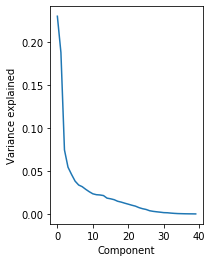

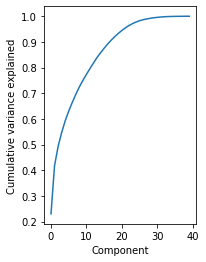

In [135]:
pca = PCA()
pca.fit(x) # fit pca on the feature space to get the principal components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
cumulative_explained_variance_percent = list(np.round(cumulative_explained_variance_ratio*100,2))
print('Cumulative explained variance by components (%)')
for i in range(1,31):
    print(' %d components: %.2f' % (i, cumulative_explained_variance_percent[i-1]))

# plot of explained variance 
plt.subplot(1, 2, 1)
plt.plot(explained_variance_ratio)
plt.ylabel('Variance explained')
plt.xlabel('Component')
plt.show()

# plot of cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(cumulative_explained_variance_ratio)
plt.ylabel('Cumulative variance explained')
plt.xlabel('Component')
plt.show()

Visualise the feature space in two dimensions:

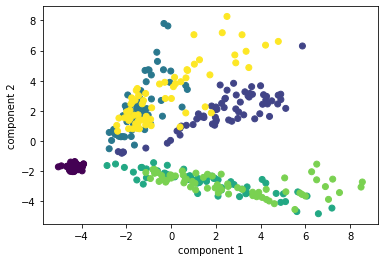

In [136]:
x_transformed = pca.transform(x)
plt.scatter(x_transformed[:, 0], x_transformed[:, 1], c=y)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

Moving forward, the feature space is reduced down to 20, halfing the dimensionality whilst retaining 93% of the explained variance in the feature space. 

In [137]:
num_dimensions = 20
x = x_transformed[:, 0:num_dimensions]

## Classification
With the features extracted, classifier models can now be trained and evaluated. Firstly, the training set is split into a training and validation set

In [138]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25)

Define a function to evaluate a models performance with accuracy and a confusion matrix

In [139]:
def test_model(model, x, y, dataset_type):
    y_pred = model.predict(x)
    acc = accuracy_score(y, y_pred) * 100
    print('Overall accuracy on %s set: %.2f %%' % (dataset_type, acc))
    print('Confusion matrix:')
    targets = sorted(y.unique())
    plot_confusion_matrix(model, x, y, labels=targets)
    plt.show()

Fit a multiclass logistic regression model on the training data and evaluate

Overall accuracy on train set: 99.67 %
Confusion matrix:


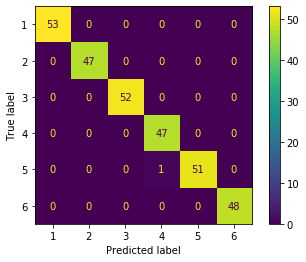

Overall accuracy on validation set: 97.00 %
Confusion matrix:


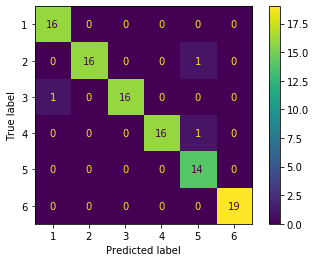

In [140]:
logreg = LogisticRegression(multi_class='multinomial').fit(x_train, y_train)
test_model(logreg, x_train, y_train, 'train')
test_model(logreg, x_val, y_val, 'validation')

##### Balancing the dataset
Although the dataset is largely balanced (see data exploration section), there are techniques to make it more so: 
 - Method 1 - class weights - with this technique, when computing error during training, errors of classes with less instances are weighted more
 - Method 2 - SMOTE (Synthetic Minority Oversampling Technique) - oversamples classes with less instances, to create instances that are new (i.e. not just copies)

Overall accuracy on validation set: 97.00 %
Confusion matrix:


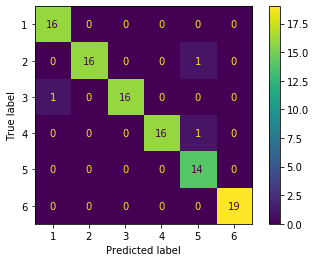

C:\Users\tomry\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tomry\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tomry\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tomry\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, cate

Overall accuracy on validation set: 97.00 %
Confusion matrix:


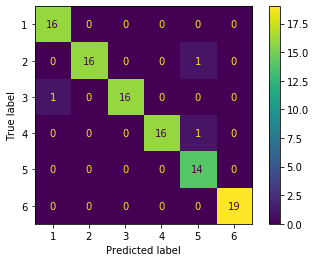

In [141]:
# method 1 - use class weights
logreg1 = LogisticRegression(multi_class='multinomial', class_weight='balanced').fit(x_train, y_train)
test_model(logreg1, x_val, y_val, 'validation')

# method 2 - SMOTE
oversample = SMOTE()
x_smote, y_smote = oversample.fit_resample(x_train, y_train) # x and y returned as numpy arrays
logreg2 = LogisticRegression(multi_class='multinomial').fit(x_smote, y_smote)
test_model(logreg2, x_val, y_val, 'validation')

These models perform similarly well on the validation set. It can therefore be seen logistic regression is an appropriate classifier for this data, given adequate feature extraction. For a different type of classifier, given the small number of samples in the feature space, A k-nearest neighbours classifier will be optimised, trained and evaluated. 

Best k: 16
Overall accuracy on validation set: 90.00 %
Confusion matrix:


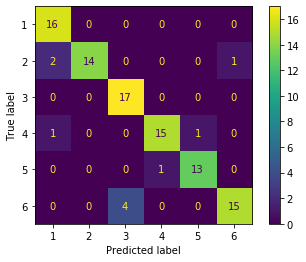

In [142]:
k_grid = list(range(1, 40, 1))
params = {'n_neighbors':k_grid}
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, params, refit=True)
gs.fit(x, y)
print('Best k: %d' % gs.best_params_['n_neighbors'])
knn = gs.best_estimator_
test_model(knn, x_val, y_val, 'validation')

## Testing 
The models are now tested on unseen test data from subject 03. 

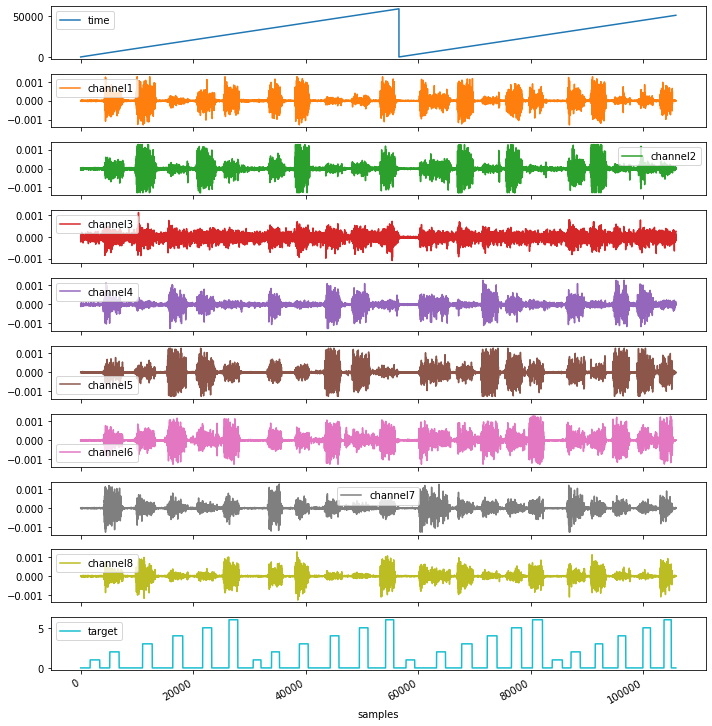

In [143]:
test_data_paths = [r'...\EMG_data_for_gestures-master\03\1_raw_data_09-32_11.04.16.txt',
                   r'...\EMG_data_for_gestures-master\03\2_raw_data_09-34_11.04.16.txt']

raw_emg_test = load_data(test_data_paths)
plot_all_channels(raw_emg_test, 0, len(raw_emg_test))

Carry out the same steps on the test data

In [144]:
# preprocess
raw_emg_test = preprocess(raw_emg_test)
# extract features
x_test, y_test = feature_extraction(raw_emg_test)
# standardise with training sets statistics
x_test = scaler.transform(x_test)
# reduce dimensionality
x_test = pca.transform(x_test)
x_test = x_test[:, 0:num_dimensions]

And test the models on the test set

Overall accuracy on test set: 82.15 %
Confusion matrix:


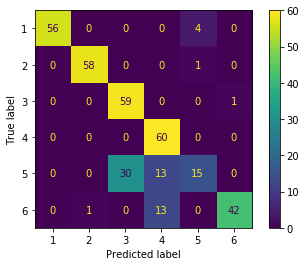

Overall accuracy on test set: 82.15 %
Confusion matrix:


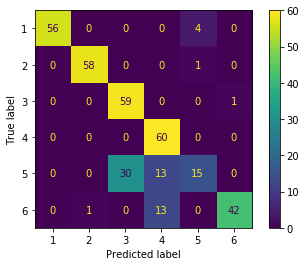

Overall accuracy on test set: 82.15 %
Confusion matrix:


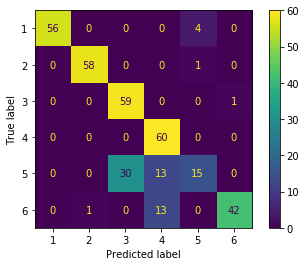

Overall accuracy on test set: 82.44 %
Confusion matrix:


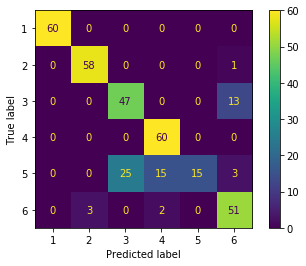

In [145]:
test_model(logreg, x_test, y_test, 'test') # normal logistic regression
test_model(logreg1, x_test, y_test, 'test') # logistic regression with class weights
test_model(logreg2, x_test, y_test, 'test') # logistic regression trained on SMOTE data
test_model(knn, x_test, y_test, 'test') # knn

## Analysis and next steps
All the models performed similarly well on the test data. Interestingly, for all models, they perform badly at predicting gesture 5 - radial deviations, often predicting gesture 3, wrist flexion instead. This is because the test data comes from a different subject, and thus the test data is of a different distribution to the training data. To overcome this issue, techniques such as incremental learning, in which the classifier is retrained on some data from the new subject, have been suggested.

Additional steps to improve performance could be:
- Relabelling - there is much data labelled class 0 during contraction of a gesture, as seen in the plots of the raw EMG signals. A different labelling approach could be used to more accurately segment the signals, and thus increase the amount of data per gesture
- Features - in this work, only 6 different features were extracted (4 time domain, 2 frequency domain). Further experimentation with other features could be carried out, to find ones that more effectively discriminate between different gestures. With the feature space, a different dimensionality reduction technique could be tried as well, for example with sklearns recursive feature elimination